In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
import scipy
import operator
from keras import backend as K

Using TensorFlow backend.


In [2]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications import Xception, ResNet50

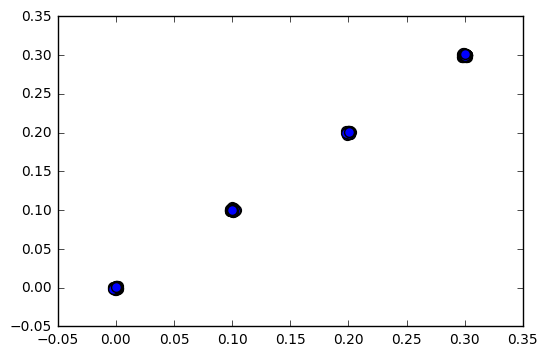

In [3]:
def draw(m,s):
    X = np.random.normal(m,s, 100*2)
    plt.scatter(X[:int(len(X)/2)],X[int(len(X)/2):], s=50)
    
draw(0,0.001)
draw(0.1,0.001)
draw(0.2,0.001)
draw(0.3,0.001)

plt.show()

In [4]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input, BatchNormalization, GlobalAveragePooling2D
import os


In [5]:
noise_dim = 64
batch = 64
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [7]:
label = lambda x: np.array([1,0]) if x == 0 else np.array([0,1])

y_noise = np.zeros((len(y_train), noise_dim))
for i, yy in enumerate(y_train):
    y_noise[i] = np.random.normal(float(yy.argmax()/10),0.0001, noise_dim)

def generate():
    while True:
        step = 0
        for b in range(int(len(x_train)/batch)):
            itr=0
            X = np.zeros((batch,32,32,3))
            Y = np.zeros((batch, num_classes))
            Yn = np.zeros((batch, noise_dim))
            for x_, y_ in zip(x_train[step:step+batch] ,y_train[step:step+batch]):
                X[itr] = x_
                Y[itr] = y_
                Yn[itr] = np.random.normal(float(y_.argmax()/10),0.01, noise_dim)
#                 Yn[itr] = yn
    
                itr+=1
                
            step+=batch
#             yield (X,[Y,Yn])
            yield (X,Yn)

In [13]:
# inputs = Input(shape = (32,32,3))
# x = Conv2D(64, (3, 3), padding="same")(inputs)
# x = Activation("relu")(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(3, 3))(x)
# x = Dropout(0.25)(x)
 
# x = Conv2D(64, (3, 3), padding="same")(x)
# x = Activation("relu")(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

# x = Conv2D(128, (3, 3), padding="same")(x)
# x = Activation("relu")(x)
# x = BatchNormalization()(x)
# x = Dropout(0.25)(x)

# x = Conv2D(128, (3, 3), padding="same")(x)
# x = Activation("relu")(x)
# x = BatchNormalization()(x)
# x = Dropout(0.25)(x)

# x = Conv2D(128, (3, 3), padding="same")(x)
# x = Activation("relu")(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

# x = Conv2D(256, (3, 3), padding="same")(x)
# x = Activation("relu")(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# x = Dense(100, activation='relu')(x)

# out1 = Dense(10, activation='softmax', name="category_output")(x)
# out2 = Dense(noise_dim, activation='linear', name = "noise")(x)

# #model = Model(inputs=inputs, outputs=[out1,out2])
# model = Model(inputs=inputs, outputs=out2)

bmodel = Xception(weights='imagenet', include_top=False, input_shape=(None, None, 3))

x = GlobalAveragePooling2D()(bmodel.layers[-1].output)
x = BatchNormalization()(x)
x = Dense(100, activation='linear')(x)
out1 = Dense(10, activation='softmax', name="category_output")(x)
out2 = Dense(noise_dim, activation='sigmoid', name = "noise")(x)
model = Model(bmodel.input, [out1,out2])
# model = Model(bmodel.input, out2)

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [16]:
losses = {
    "category_output": "binary_crossentropy",
    "noise": keras.losses.MAE,
}

In [1]:
model.compile(loss=losses,
              optimizer=keras.optimizers.Adam(lr=0.0000652),
              metrics=['accuracy'])

model.fit_generator(generate(), 
                    steps_per_epoch=int(len(x_train)/batch),
                    epochs=2000
                   )

In [65]:
model.save('exp3.hdf5')

In [43]:
vec_model=Model(model.input, model.layers[-2].output)

In [45]:
#vecs = np.zeros((len(x_train),noise_dim))
vecs = np.zeros((len(x_test),100))
for i,x in enumerate(x_test):
    #pred = model.predict(np.expand_dims(x,axis=0))
    #vecs[i] = pred[1][0]
    pred = vec_model.predict(np.expand_dims(x,axis=0))
    vecs[i] = pred[0]
    

In [46]:
def similar(ind):
    #pred = model.predict(np.expand_dims(x_train[ind],axis=0))
    #vec_query = pred[1][0]
    
    pred = vec_model.predict(np.expand_dims(x_train[ind],axis=0))
    vec_query = pred[0]
#     print(vec_query)
    dict_={}
    dict_cos={}
    for i,x in enumerate(vecs):
        distance = scipy.spatial.distance.euclidean(x, vec_query)
        distance_cos = scipy.spatial.distance.cosine(x, vec_query)
        
        if distance in dict_:
            distance+=(0.0000001/i)
        dict_.update({distance:i})
        
        if distance_cos in dict_cos:
            distance_cos+=(0.0000001/i)
        dict_cos.update({distance_cos:i})        
    
    return dict_,dict_cos

In [ ]:
ind = np.random.randint(len(y_train))
#33078 46993 49426 39277 211 131 457
plt.imshow(x_train[ind])
plt.show()

In [ ]:
dict_, dict_cos = similar(ind)
sorted_x = sorted(dict_.items(), key=operator.itemgetter(0), reverse=False)
sorted_c = sorted(dict_cos.items(), key=operator.itemgetter(0), reverse=False)
for i,c in zip(sorted_x[:10],sorted_c[:10]):
    plt.figure(figsize=(2,4))
    
    plt.imshow(np.concatenate((x_test[i[1]],x_test[c[1]]),axis=0))
    plt.show()


In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.manifold import TSNE

In [53]:
tsne = TSNE().fit_transform(vecs)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

In [54]:
import matplotlib.pyplot as plt
from PIL import Image
width = 4000
height = 3000
max_dim = 100
full_image = Image.new('RGB', (width, height))
for idx, x in enumerate(x_test):
    tile = Image.fromarray(np.uint8(x * 255))
    rs = max(1, tile.width / max_dim, tile.height / max_dim)
    tile = tile.resize((int(tile.width / rs),
                        int(tile.height / rs)),
                       Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim) * tx[idx]),
                            int((height-max_dim) * ty[idx])))

In [55]:
full_image.save('full_image_xception_noise_MAE_1.jpg')